In [179]:
import warnings
warnings.filterwarnings("ignore")

In [818]:
from typing import Dict, List, Callable, Any
from torchvision import datasets
import torchvision
from transformers import AutoFeatureExtractor, RegNetModel

import torch
import numpy as np
import pandas as pd
import pickle

from torch.utils.data import SubsetRandomSampler, DataLoader, Subset, Dataset
import torch.optim as optim
from PIL import Image
import concurrent.futures as pool
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## Init

In [227]:
feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/regnet-y-320-seer")
model = RegNetModel.from_pretrained("facebook/regnet-y-320-seer")

In [182]:
def extract_img_features(img: Image) -> torch.Tensor:
    inputs = feature_extractor(img, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.pooler_output

In [183]:
def save_to_local(_to_save: Any, name="extracted_dataset") -> None:
    with open(f"{name}.pickle", "wb") as handle:
        pickle.dump(_to_save, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
# def save_dataset(name: str, dataset: datasets.ImageFolder, indexes=None) -> None:
#     tmp_dataset = []
#     def task(x, tmp_dataset=tmp_dataset, dataset=dataset, count=count):
#         print(x)
#         return {
#             "image_tensor": dataset[x][0],
#             "class": dataset[x][1],
#         }

#     if indexes is None:
#         indexes = range(len(dataset))
#     else:
#         indexes = (idx for idx in indexes)
#     results = [task(idx) for idx in indexes]
#     save_to_local(results, name=name)


def save_dataset(
    name: str, dataset: datasets.ImageFolder, indexes=None, max_workers=8
) -> None:
    def task(x, dataset=dataset):
        return {
            "image_tensor": dataset[x][0],
            "class": dataset[x][1],
        }

    if indexes is None:
        indexes = range(len(dataset))
    else:
        indexes = (idx for idx in indexes)

    with pool.ThreadPoolExecutor(max_workers=max_workers) as executer:
        results = executer.map(task, indexes)
    save_to_local(list(results), name=name)

In [137]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

In [9]:
VAL_DATASET_SIZE = 0.2
RANDOM_SEED = 42
IMAGES_DIR = "archive"

## Dataset examples

In [138]:
random_images = np.random.randint(70000, size=16)
random_images = [datasets.ImageFolder(IMAGES_DIR)[img_idx][0] for img_idx in random_images]

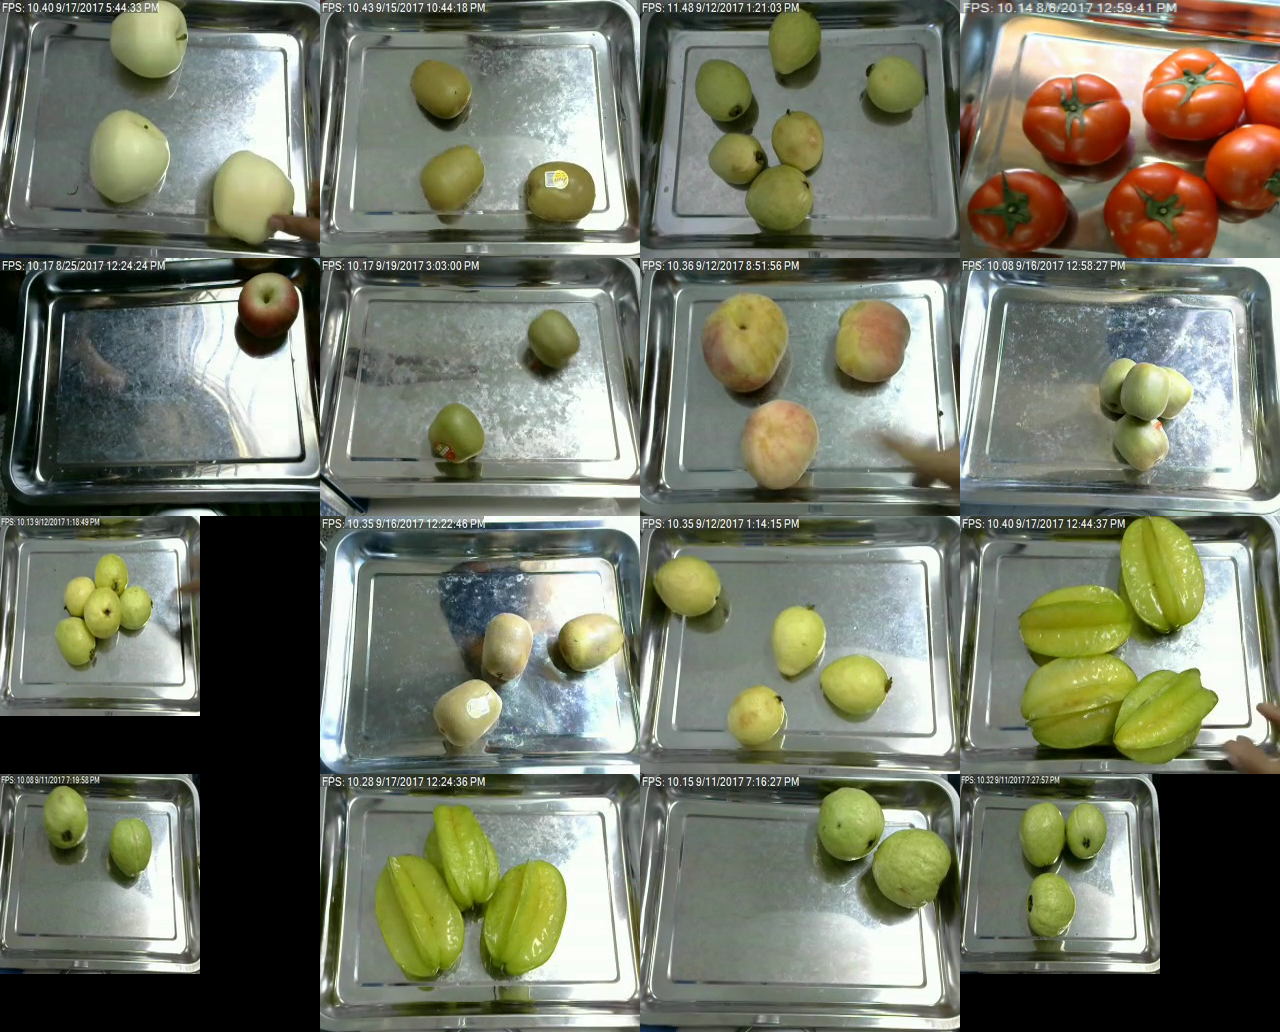

In [139]:
grid = image_grid(random_images, rows=4, cols=4)
grid

In [787]:
classes_map = {
    0: "Apple",
    1: "Banana",
    2: "Carambola",
    3: "Guava",
    4: "Kiwi",
    5: "Mango",
    6: "muskmelon",
    7: "Orange",
    8: "Peach",
    9: "Pear",
    10: "Persimmon",
    11: "Pitaya",
    12: "Plum",
    13: "Pomegranate",
    14: "Tomatoes",
}

## Extracted features dataset

In [176]:
extracted_dataset = datasets.ImageFolder(IMAGES_DIR, extract_img_features)

In [177]:
extracted_dataset  # img dataset with transformer

Dataset ImageFolder
    Number of datapoints: 70549
    Root location: archive
    StandardTransform
Transform: <function extract_img_features at 0x7fd9c4f11280>

## Train / Val indices split

In [162]:
dataset_size = len(extracted_dataset)
dataset_indices = list(range(dataset_size))
np.random.seed(RANDOM_SEED)
np.random.shuffle(dataset_indices)

val_split_index = int(np.floor(VAL_DATASET_SIZE * dataset_size))

train_idx, val_idx = (
    dataset_indices[val_split_index:],
    dataset_indices[:val_split_index],
)

In [163]:
train_size, val_size = 1000, 300 
# 10k images too long (+- 3 days)
# and now google colab resourses are not available without subscription:(

In [164]:
train_extracted_dataset = Subset(extracted_dataset, train_idx[:train_size])
val_extracted_dataset = Subset(extracted_dataset, val_idx[:val_size])

## Save to local

In [15]:
train_dataset_name, val_dataset_name = (
    "train_extracted_dataset",
    "val_extracted_dataset",
)

In [16]:
# save_dataset(train_dataset_name, train_extracted_dataset)

In [17]:
# save_dataset(val_dataset_name, val_extracted_dataset)

## Load Dataset

In [260]:
with open(f"{train_dataset_name}.pickle", "rb") as handle:
    train_loaded_dataset = pickle.load(handle)

In [261]:
with open(f"{val_dataset_name}.pickle", "rb") as handle:
    val_loaded_dataset = pickle.load(handle)

In [262]:
def dim_reduction(x: Dict) -> Dict:
    # drop useless dimensions
    x = x.copy()
    x["image_tensor"] = x["image_tensor"][0, :, 0, 0]
    return x


class DatasetFromExtractedFeatures(Dataset):
    def __init__(self, dataset_dict: Dict, transform: Callable = dim_reduction):
        self.dataset_dict = dataset_dict
        self.transform = transform

    def __len__(self):
        return len(self.dataset_dict)

    def __getitem__(self, idx):
        item = self.dataset_dict[idx]
        if self.transform:
            item = self.transform(item)
        return item["image_tensor"], item["class"]

In [263]:
train_dataset = DatasetFromExtractedFeatures(train_loaded_dataset)
val_dataset = DatasetFromExtractedFeatures(val_loaded_dataset)

In [264]:
train_dataset_loaded = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset_loaded = DataLoader(val_dataset, batch_size=1, shuffle=True)

### Image classes

In [265]:
train_classes, val_classes = {item[1] for item in train_dataset}, {item[1] for item in val_dataset}

In [266]:
train_classes

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}

In [267]:
val_classes

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}

## Classificator

In [503]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self, p=0.15):
        super(NeuralNetwork, self).__init__()
        self.flatten = torch.nn.Flatten()
        self.linear_relu_stack = torch.nn.Sequential(
            torch.nn.Linear(3712, 1000),
            torch.nn.ReLU(),
            torch.nn.Linear(1000, 512),
            torch.nn.ReLU(),
            torch.nn.Dropout(p),
            torch.nn.Linear(512, 15),
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        return x

In [504]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [505]:
classificator = NeuralNetwork().to(device)

In [506]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(classificator.parameters())

### Train model

In [507]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [508]:
epochs = 50
train_losses, val_losses = [], []
for e in range(1, epochs + 1):
    classificator.train()
    train_loss = 0
    for X_batch, y_batch in train_dataset_loaded:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()

        y_pred = classificator(X_batch)

        loss = criterion(y_pred, y_batch)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_losses.append(train_loss)

    classificator.eval()
    with torch.no_grad():
        val_loss = 0
        for X_batch, y_batch in val_dataset_loaded:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_pred = classificator(X_batch)
            loss = criterion(y_pred, y_batch)

            val_loss += loss.item()

    val_losses.append(val_loss)

    print(
        f"Epoch {e+0:03}: | Train Loss: {train_loss/len(train_dataset_loaded):.5f} | Val Loss: {val_loss/len(val_dataset_loaded):.5f} | "
    )

Epoch 001: | Train Loss: 2.38186 | Val Loss: 2.19394 | 
Epoch 002: | Train Loss: 2.02474 | Val Loss: 1.88164 | 
Epoch 003: | Train Loss: 1.62339 | Val Loss: 1.51599 | 
Epoch 004: | Train Loss: 1.23432 | Val Loss: 1.21879 | 
Epoch 005: | Train Loss: 0.94608 | Val Loss: 0.95081 | 
Epoch 006: | Train Loss: 0.70794 | Val Loss: 0.87313 | 
Epoch 007: | Train Loss: 0.54849 | Val Loss: 0.56959 | 
Epoch 008: | Train Loss: 0.44105 | Val Loss: 0.44994 | 
Epoch 009: | Train Loss: 0.31569 | Val Loss: 0.41885 | 
Epoch 010: | Train Loss: 0.26113 | Val Loss: 0.35839 | 
Epoch 011: | Train Loss: 0.20449 | Val Loss: 0.26887 | 
Epoch 012: | Train Loss: 0.14598 | Val Loss: 0.24375 | 
Epoch 013: | Train Loss: 0.10773 | Val Loss: 0.24776 | 
Epoch 014: | Train Loss: 0.07927 | Val Loss: 0.19160 | 
Epoch 015: | Train Loss: 0.05788 | Val Loss: 0.17790 | 
Epoch 016: | Train Loss: 0.04527 | Val Loss: 0.11338 | 
Epoch 017: | Train Loss: 0.03519 | Val Loss: 0.12309 | 
Epoch 018: | Train Loss: 0.03011 | Val Loss: 0.1

### Model evaluation

In [509]:
def model_predict(model: Any, data) -> int:
    outputs = classificator(data)
    _, predicted = torch.max(outputs.data, 1)
    return predicted

In [510]:
classificator.eval()

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3712, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1000, out_features=512, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.15, inplace=False)
    (5): Linear(in_features=512, out_features=15, bias=True)
  )
)

In [511]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_dataset_loaded:
        predicted = model_predict(classificator, images)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the network on the 300 test images: {100 * correct // total} %")

Accuracy of the network on the 300 test images: 97 %


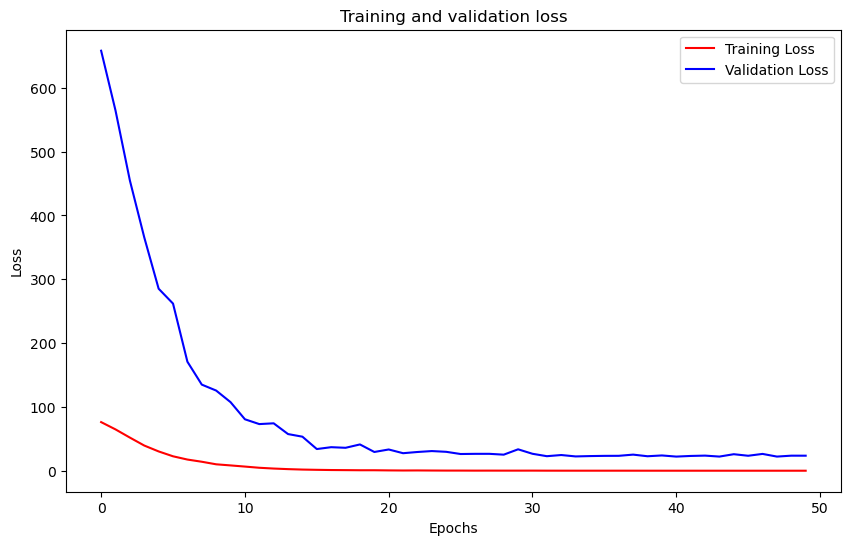

In [512]:
tmp_epochs = range(len(train_losses))
plt.figure(figsize=(10, 6))
plt.plot(tmp_epochs, train_losses, 'r', label="Training Loss")
plt.plot(tmp_epochs, val_losses, 'b', label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and validation loss")
plt.show()

+- 20 epochs is enough and may be reduce the number of layers / neurons would can smooth overfitting

### Save model

In [515]:
# model_name = "model_v1"
# save_to_local(classificator, name=model_name)

### Load model

In [516]:
with open(f"{model_name}.pickle", "rb") as handle:
    model_loaded = pickle.load(handle)

### Test some new images

In [517]:
model_loaded.eval()
for img_idx in range(-5, -1):
    print(
        f"predict: {int(model_predict(model_loaded, val_extracted_dataset[img_idx][0]))} | class: {val_extracted_dataset[img_idx][1]}"
    )

predict: 0 | class: 0
predict: 4 | class: 4
predict: 3 | class: 3
predict: 9 | class: 9


### Confusion matrix

In [518]:
val_pred, val_true = [], []
for image, label in val_dataset_loaded:
    val_pred.append(int(model_predict(model_loaded, image)))
    val_true.append(int(label))

In [519]:
cm_val = confusion_matrix(val_true, val_pred)

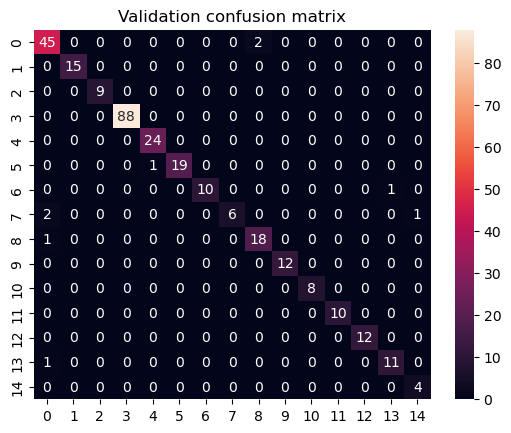

In [528]:
sns.heatmap(cm_val, annot=True)
plt.title("Validation confusion matrix");

In [521]:
train_pred, train_true = [], []
for image, label in train_dataset_loaded:
    for img, lab in zip(model_predict(model_loaded, image), label):
        train_pred.append(int(img))
        train_true.append(int(lab))

In [522]:
cm_train = confusion_matrix(train_true, train_pred)

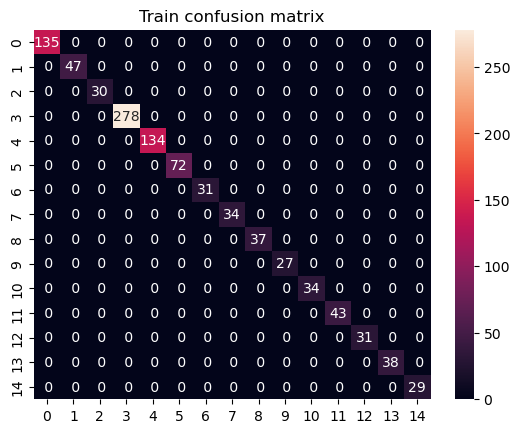

In [529]:
sns.heatmap(cm_train, annot=True, fmt="2g");
plt.title("Train confusion matrix");

a bit overfitted model, but we dont care 

## Cosine similarity

In [770]:
num_classes = 15
numpy_dataset, numpy_classes = [], []
cos_matrix = np.zeros((num_classes, num_classes))

for img, lab in list(train_dataset_loaded):
    numpy_dataset.append(img.numpy())
    numpy_classes.append(lab.numpy())

numpy_dataset = np.concatenate(numpy_dataset)
numpy_classes = np.concatenate(numpy_classes)
classes = np.arange(num_classes)

In [771]:
numpy_dataset.shape

(1000, 3712)

In [772]:
numpy_classes.shape

(1000,)

In [773]:
for i in range(num_classes):
    for j in range(num_classes):
        fruit_i = numpy_dataset[np.where(numpy_classes == i)]
        fruit_j = numpy_dataset[np.where(numpy_classes == j)]
        cos_similarity = cosine_similarity(fruit_i, fruit_j)
        cos_matrix[i][j] = np.mean(cos_similarity)

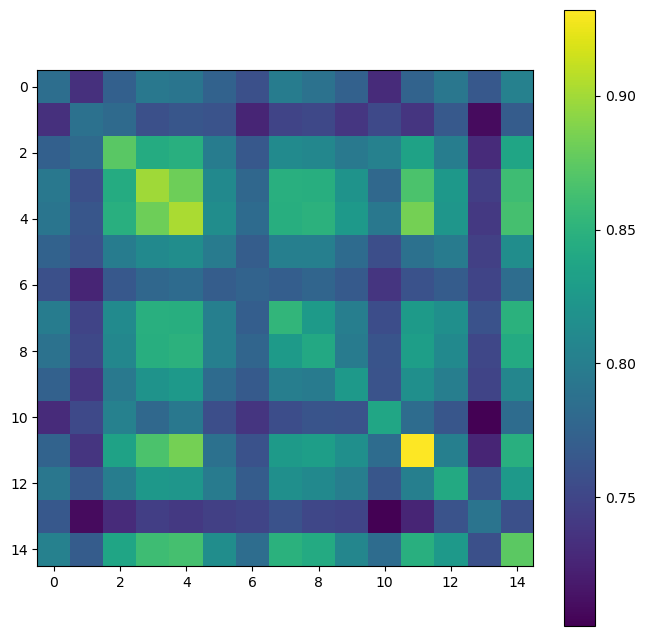

In [774]:
plt.figure(figsize=(8, 8))
plt.imshow(cos_matrix)
plt.colorbar();

In [788]:
classes_map[11]

'Pitaya'

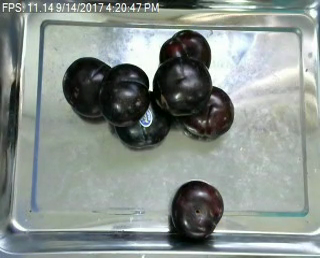

In [792]:
datasets.ImageFolder(IMAGES_DIR)[63000][0]

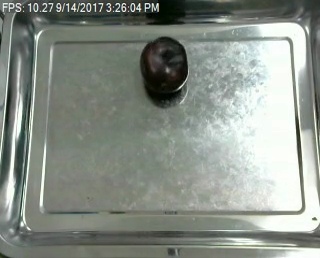

In [793]:
datasets.ImageFolder(IMAGES_DIR)[63050][0]

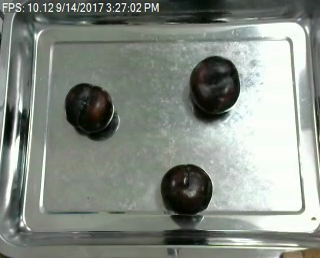

In [794]:
datasets.ImageFolder(IMAGES_DIR)[63100][0]

Most similar pictures in dataset - Pitaya

## PCA

In [796]:
pca = PCA(n_components=2)

In [797]:
X_r = pca.fit(numpy_dataset).transform(numpy_dataset)

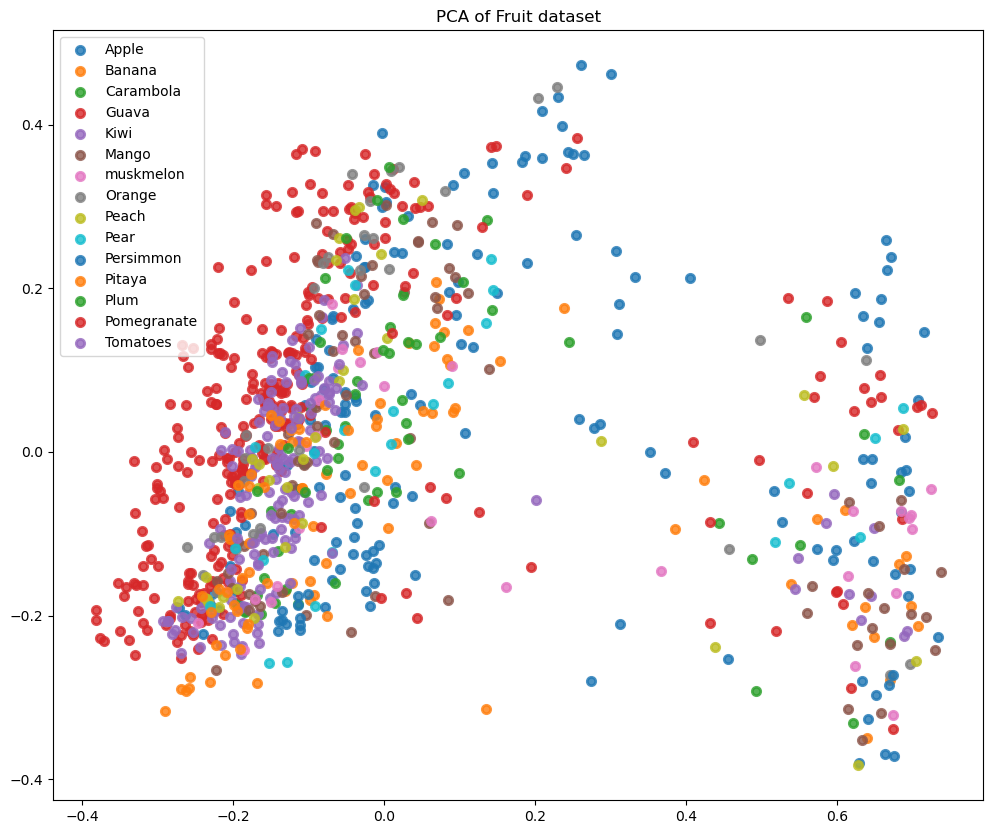

In [821]:
plt.figure(figsize=(12, 10))
lw = 2

for i, target_name in zip(classes_map.keys(), classes_map.values()):
    plt.scatter(
        X_r[numpy_classes == i, 0],
        X_r[numpy_classes == i, 1],
        alpha=0.8,
        lw=lw,
        label=target_name,
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of Fruit dataset");

## LDA

In [822]:
lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(numpy_dataset, numpy_classes).transform(numpy_dataset)

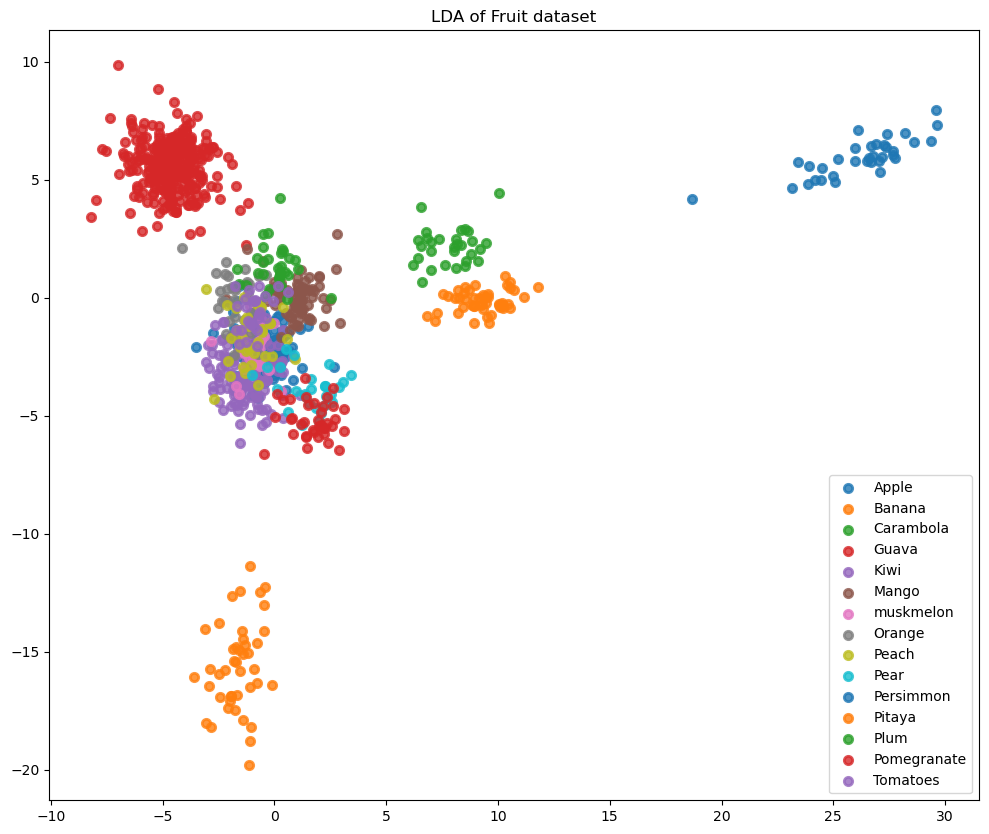

In [824]:
plt.figure(figsize=(12, 10))
lw = 2

for i, target_name in zip(classes_map.keys(), classes_map.values()):
    plt.scatter(
        X_r2[numpy_classes == i, 0],
        X_r2[numpy_classes == i, 1],
        alpha=0.8,
        lw=lw,
        label=target_name,
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("LDA of Fruit dataset");